In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32

In [3]:
# Paths (change these if your dataset is in another location)
train_dir = 'dataset_split/train'  # 👈 Replace with your actual train path
val_dir = 'dataset_split/val'      # 👈 Replace with your actual val path


In [4]:
# ✅ Data Augmentation + Normalization for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)


In [5]:
# ✅ Normalization for validation (no augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [6]:
# ✅ One-hot encoded data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 185004 images belonging to 4 classes.


In [7]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 20556 images belonging to 4 classes.


In [8]:
# ✅ Base model (EfficientNetB0)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3))
)
base_model.trainable = False  # Freeze base for initial transfer learning


In [9]:
from tensorflow.keras.layers import (
    SeparableConv2D, BatchNormalization, Flatten, Dropout, Dense, LeakyReLU
)
from tensorflow.keras.models import Model

# Base model output
x = base_model.output  # Make sure base_model is already defined and its output shape is known

# First SeparableConv block
x = SeparableConv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Second SeparableConv block
x = SeparableConv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Flatten instead of GAP
x = Flatten()(x)
x = Dropout(0.4)(x)

# Fully connected layers
x = Dense(256)(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)

x = Dense(128)(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

# Output layer
output = Dense(4, activation='softmax')(x)



In [11]:

# ✅ Final model

# Final model
model = Model(inputs=base_model.input, outputs=output)


In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


In [17]:
# ✅ Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
5782/5782 [==============================] - 593s 102ms/step - loss: 0.5026 - accuracy: 0.9273 - val_loss: 0.5244 - val_accuracy: 0.9090
Epoch 2/20
5782/5782 [==============================] - 595s 103ms/step - loss: 0.5003 - accuracy: 0.9289 - val_loss: 0.5220 - val_accuracy: 0.9102
Epoch 3/20
5782/5782 [==============================] - 594s 103ms/step - loss: 0.4981 - accuracy: 0.9301 - val_loss: 0.5263 - val_accuracy: 0.9081
Epoch 4/20
5782/5782 [==============================] - 591s 102ms/step - loss: 0.4965 - accuracy: 0.9306 - val_loss: 0.5259 - val_accuracy: 0.9089
Epoch 5/20
5782/5782 [==============================] - 590s 102ms/step - loss: 0.4949 - accuracy: 0.9316 - val_loss: 0.5234 - val_accuracy: 0.9110
Epoch 6/20
5782/5782 [==============================] - 596s 103ms/step - loss: 0.4933 - accuracy: 0.9323 - val_loss: 0.5221 - val_accuracy: 0.9081
Epoch 7/20
5782/5782 [==============================] - 595s 103ms/step - loss: 0.4912 - accuracy: 0.9337 - val_

In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [19]:
# ✅ Ensure validation generator doesn't shuffle (to match order)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 20556 images belonging to 4 classes.


In [20]:
# ✅ Predict on validation set
y_pred_probs = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# ✅ Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


643/643 [==============================] - 48s 74ms/step
Classification Report:
              precision    recall  f1-score   support

         CNV       0.92      0.92      0.92      5139
         DME       0.90      0.88      0.89      5139
      DRUSEN       0.85      0.85      0.85      5139
      NORMAL       0.95      0.99      0.97      5139

    accuracy                           0.91     20556
   macro avg       0.91      0.91      0.91     20556
weighted avg       0.91      0.91      0.91     20556



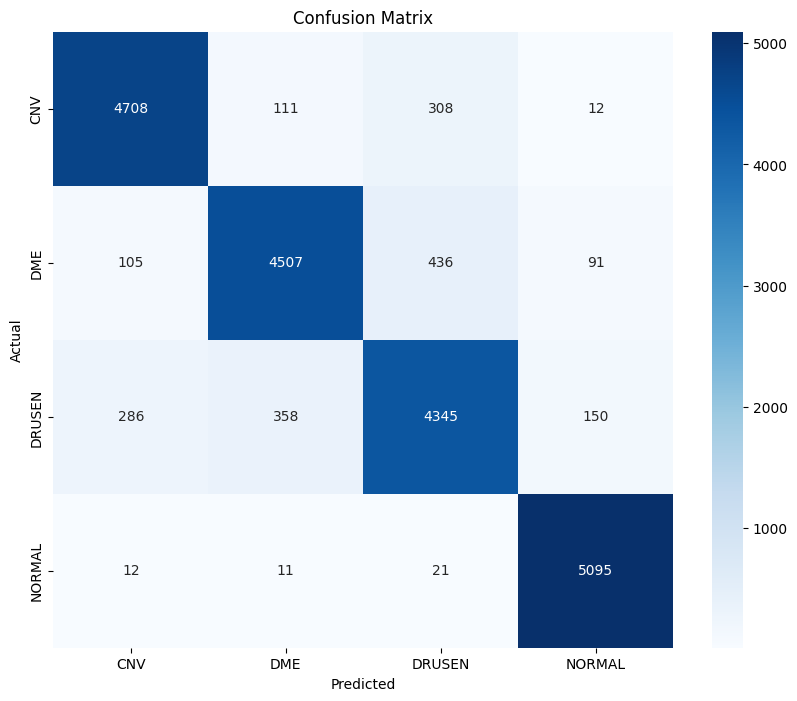

In [21]:
# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Path to the test image
img_path = "Screenshot 2025-05-03 032923.png"  # 👈 Replace with your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)        # Normalize


In [27]:
# Make prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
confidence = np.max(predictions[0])


1/1 [==============================] - 1s 1s/step


In [28]:
# Get class label mapping
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class_name} (Confidence: {confidence:.2f})")


Predicted class: CNV (Confidence: 1.00)


In [29]:
print("Scanning inside model layers...")

for layer in model.layers:
    for attr_name in dir(layer):
        if attr_name.startswith("_"):
            continue
        try:
            attr_value = getattr(layer, attr_name)
        except Exception:
            continue  # Skip attributes that throw errors

        if isinstance(attr_value, tf.Tensor):
            print(f"⚡ Found Tensor in layer '{layer.name}' attribute: '{attr_name}'")
        elif isinstance(attr_value, (list, tuple)):
            for item in attr_value:
                if isinstance(item, tf.Tensor):
                    print(f"⚡ Found Tensor inside list/tuple in layer '{layer.name}' attribute: '{attr_name}'")
        elif isinstance(attr_value, dict):
            for key, item in attr_value.items():
                if isinstance(item, tf.Tensor):
                    print(f"⚡ Found Tensor inside dict in layer '{layer.name}' at key '{key}'")


Scanning inside model layers...
⚡ Found Tensor in layer 'normalization' attribute: 'mean'
⚡ Found Tensor in layer 'normalization' attribute: 'variance'
⚡ Found Tensor in layer 'rescaling_1' attribute: 'scale'


C:\Users\DELL\AppData\Local\Temp\ipykernel_18356\4088505527.py:8: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  attr_value = getattr(layer, attr_name)


In [30]:
model.get_layer('normalization').mean = model.get_layer('normalization').mean.numpy()
model.get_layer('normalization').variance = model.get_layer('normalization').variance.numpy()
model.get_layer('rescaling_1').scale = model.get_layer('rescaling_1').scale.numpy()


In [32]:
model.save("model_save.keras")

In [1]:
from tensorflow import keras

model = keras.models.load_model("model_save.keras")


In [2]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Path to the test image
img_path = "dme_1132061_1.jpg"  # 👈 Replace with your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)        # Normalize


In [3]:
# Make prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
confidence = np.max(predictions[0])


1/1 [==============================] - 7s 7s/step


In [6]:
# Get class label mapping
class_indices = {0:"CNV", 1:"DME", 2:"DRUSEN", 3:"NORMAL"}
class_names = list(class_indices.keys())

predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class_name} (Confidence: {confidence:.2f})")


Predicted class: 1 (Confidence: 1.00)
